In [1]:
# This is used to report the totaal running time of the notebook
import time
start = time.time()

In [2]:
# Importing all the packages
import io
import re
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing

from datetime import timedelta
from keras.models import Sequential
from keras.models import load_model
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Defining the paths to the train and test data
path_test = 'BPI_Challenge_2012-test.csv'
path_train = 'BPI_Challenge_2012-training.csv'

In [4]:
# Importing the test and train data
df_train = pd.read_csv (path_train)
df_test = pd.read_csv (path_test)

In [5]:
# This cell "cleans" the data by keeping in test set only cases 
# that started in test and not those that started in train

train_cases = list(set(list(df_train['case concept:name'])))
test_cases = list(set(list(df_test['case concept:name'])))
test_keep = [item for item in test_cases if item not in train_cases]

df_test = df_test[df_test['case concept:name'].isin(test_keep)]

# df_show will be the df to which we will add the 2 columns and then export
df_show = df_test.copy()

In [6]:
# Converting sting to timestamp
df_train['event time:timestamp']= pd.to_datetime(df_train['event time:timestamp'])

# Sorting by first case nr and then by timestamp
df_train = df_train.sort_values(by=['case concept:name', 'event time:timestamp'])

# Creating a new column with the next activity
df_train = df_train.assign(actualaction=(df_train.groupby('case concept:name')['event concept:name'].shift(-1)))

# Creating a new column with the actual time of the next activity
df_train = df_train.assign(nexttime=(df_train.groupby('case concept:name')['event time:timestamp'].shift(-1)))
# Creating a new column with the time remianing until the next activity
df_train['tonext'] = (df_train.nexttime - df_train['event time:timestamp']).astype('timedelta64[s]')

In [7]:
# Converting sting to timestamp
df_test['event time:timestamp']= pd.to_datetime(df_test['event time:timestamp'])

# Sorting by first case nr and then by timestamp
df_test = df_test.sort_values(by=['case concept:name', 'event time:timestamp'])

# Creating a new column with the next activity
df_test = df_test.assign(actualaction=(df_test.groupby('case concept:name')['event concept:name'].shift(-1)))

# Creating a new column with the actual time of the next activity
df_test = df_test.assign(nexttime=(df_test.groupby('case concept:name')['event time:timestamp'].shift(-1)))
# Creating a new column with the time remianing until the next activity
df_test['tonext'] = (df_test.nexttime - df_test['event time:timestamp']).astype('timedelta64[s]')

In [8]:
# Preparing the curent action to be one-hot encoded by making them arrays
xtrain = df_train['event concept:name']
xtrain = xtrain.to_numpy()
xtest = df_test['event concept:name']
xtest = xtest.to_numpy()
x = np.concatenate((xtrain, xtest))

In [9]:
# Preparing the following action to be one-hot encoded by making them arrays
ytrain = df_train['actualaction']
ytrain = ytrain.to_numpy()
ytest = df_test['actualaction']
ytest = ytest.to_numpy()
y = np.concatenate((ytrain, ytest))

In [10]:
# Making a huge array with all 4 arrays to be encoded
onehot = np.concatenate((x, y))

In [11]:
# Encoding the labels and then one-hot encoding the arrays
targets = onehot
labelEnc = preprocessing.LabelEncoder()
new_target = labelEnc.fit_transform(targets.astype(str))
onehotEnc = preprocessing.OneHotEncoder()
onehotEnc.fit(new_target.reshape(-1, 1))
targets_trans = onehotEnc.transform(new_target.reshape(-1, 1))

In [12]:
# Assigning the training and test data for the 2 models, the x_train and 
# x_test will be the same for both and they we encoded them along with the Y 
# for the activity model, while the Y for the time model come from the tonxt
# columns in the datasets and are transformed in arrays

x_train = targets_trans.toarray()[:214377]
x_test = targets_trans.toarray()[214377:262200]
ya_train = targets_trans.toarray()[262200:-47823]
ya_test = targets_trans.toarray()[-47823:]
yt_train = df_train.tonext.fillna(0).to_numpy()
yt_test = df_test.tonext.fillna(0).to_numpy()

In [13]:
# We initialize a scaler for the Y of the time model and fit it
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.concatenate((yt_train, yt_test)).reshape(-1, 1))

MinMaxScaler()

In [14]:
# We trasform using the scaler the y_train and y_test for the time model
yt_test = scaler.transform(yt_test.reshape(-1, 1))
yt_train = scaler.transform(yt_train.reshape(-1, 1))

In [15]:
demo = 1

if demo == 0:
    # This is the model for the next activity
    model_activity = Sequential()
    model_activity.add(LSTM(32, input_shape=(25,1)))
    model_activity.add(Dense(25))

    # Here we compile the next activity model
    model_activity.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])

    # This is the model for the time prediction
    model_time = Sequential()
    model_time.add(LSTM(32, input_shape=(25,1)))
    model_time.add(Dense(1))

    # Here we compile the model for the time prediction
    model_time.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])

    # Here we fit the models using a batch size of 64 and 10 epochs
    model_time.fit(x_train, yt_train, epochs=10, batch_size=64)
    model_activity.fit(x_train, ya_train, epochs=10, batch_size=64)

    # Saving the models
    model_activity.save('activity.h5')
    model_time.save('time.h5')

else:
    # Loading the models
    model_activity = load_model('activity.h5')
    model_time = load_model('time.h5')

In [16]:
# We predict the next activity and the time using the 2 models
predicted_activity = model_activity.predict(x_test)
predicted_time = model_time.predict(x_test)

In [17]:
# We create a new array of the size of the ya_test and we then transform the 
# predicted_activity into the same format as an array outputed by the one-hot
# encoding so we can then inverse transform it and get the categorization

max_index_row = np.argmax(predicted_activity, axis=1)
convpred = np.zeros(predicted_activity.shape)

for i in range (convpred.shape[0]):
  j = max_index_row[i]
  convpred[i][j] = 1
    
newarray = np.concatenate((x_train, convpred, ya_train, ya_test))
invers_conv = onehotEnc.inverse_transform(newarray)

In [18]:
# We get the name mapping fro the activity labels and the inverse of the dict
activity_name_mapping = dict(zip(labelEnc.classes_, labelEnc.transform(labelEnc.classes_)))
inv_activity_name_mapping = {v: k for k, v in activity_name_mapping.items()}

In [19]:
# We define the 2 arrays containing the actual prediction and real next action
actpred = invers_conv[214377:262200]
actreal = invers_conv[-47823:]

In [20]:
# We create a df out of the 2 arrays
df_conf = pd.DataFrame(np.concatenate((actpred, actreal), axis = 1), columns=['pred', 'real'])

In [21]:
# Using the inverse dictionary we map back the predicted activity
df_conf['Predicted Activity'] = df_conf.pred.replace(inv_activity_name_mapping)

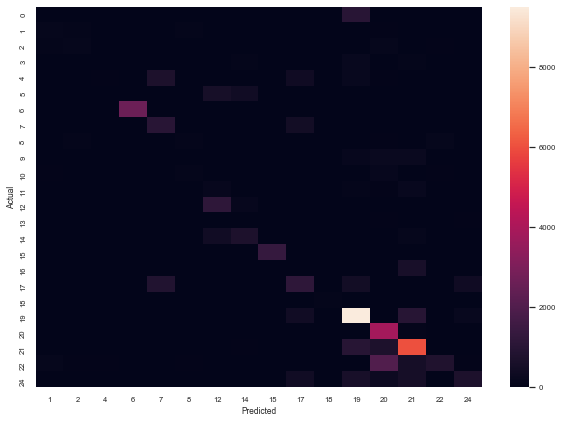

In [22]:
# We create a confusion matrix of what it should be vs what it was predicted as
confusion_matrix = pd.crosstab(df_conf.real, df_conf.pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(10,7))
sn.set(font_scale=.7) # for label size
sn.heatmap(confusion_matrix) # font size

plt.show()

In [23]:
# We get the percentage of activities that were predicted corect
accuracy_activity = 100 *len(df_conf[df_conf.pred == df_conf.real]) / len(df_conf)

In [24]:
# We transform the predicted time and the actual time back into seconds
timepred = scaler.inverse_transform(predicted_time)
timereal = scaler.inverse_transform(yt_test)

In [25]:
# We create a data frame using the 2 transformed times
temp = pd.DataFrame(np.concatenate((timepred, timereal), axis = 1), columns=['spred', 'sreal'])

In [26]:
# We get the timestamp of the activity from df_test and then create the 
# predicted timestamp using the predicted wait time in second
temp['ts'] = df_test['event time:timestamp']
temp['ctsp'] = temp.ts + temp.spred.astype('timedelta64[s]')

In [27]:
# We calulate the differences between prediction and real in sec, min, hours
temp['sdif'] = temp.sreal - temp.spred
temp['mdif'] = temp.sdif/60
temp['hdif'] = temp.mdif/60

In [28]:
# We calculate the MSE, MAE and accuracy withinh various times
msehours = (temp.hdif ** 2).mean()
meanhours = temp.hdif.mean() 
maehours = (abs(temp.hdif)).mean()
per30min = 100 * len(temp[abs(temp.mdif) - 30 < 0]) / len(temp)
per2d = 100 * len(temp[abs(temp.mdif) - 60*48 < 0]) / len(temp)
per1d = 100 * len(temp[abs(temp.mdif) - 60*24 < 0]) / len(temp)
per12h = 100 * len(temp[abs(temp.mdif) - 60*12 < 0]) / len(temp)
per6h = 100 * len(temp[abs(temp.mdif) - 60*6 < 0]) / len(temp)
per1h = 100 * len(temp[abs(temp.mdif) - 60 < 0]) / len(temp)
per5m = 100 * len(temp[abs(temp.mdif) - 5 < 0]) / len(temp)
per10m = 100 * len(temp[abs(temp.mdif) - 10 < 0]) / len(temp)
per20m = 100 * len(temp[abs(temp.mdif) - 20 < 0]) / len(temp)

In [33]:
print(f'MSE hours: {round(msehours,3)}')
print(f'MAE hours: {round(maehours,3)}')
print(f'mean hours: {round(meanhours,3)}')
print(f'percentage predicted within +- 2 days: {round(per2d, 2)}%')
print(f'percentage predicted within +- 1 day: {round(per1d, 2)}%')
print(f'percentage predicted within +- 12 hours: {round(per12h, 2)}%')
print(f'percentage predicted within +- 6 hours: {round(per6h, 2)}%')
# print(f'percentage predicted within +- 1 hour: {round(per1h, 2)}%')
# print(f'percentage predicted within +- 30 min: {round(per30min, 2)}%')
# print(f'percentage predicted within +- 20 min: {round(per20m, 2)}%')
# print(f'percentage predicted within +- 10 min: {round(per10m, 2)}%')
# print(f'percentage predicted within +- 5 min: {round(per5m, 2)}%')

print(f'percentage actions predicted correctly: {round(accuracy_activity, 2)}%')

MSE hours: 267292.786
MAE hours: 154.0
mean hours: 25.796
percentage predicted within +- 2 days: 43.44%
percentage predicted within +- 1 day: 42.73%
percentage predicted within +- 12 hours: 33.25%
percentage predicted within +- 6 hours: 1.11%
percentage actions predicted correctly: 61.64%


In [30]:
# We add the 2 predicted columns in the show df and then export it
df_show['Predicted Activity'] = df_conf['Predicted Activity']
df_show['Predicted Time Stamp'] = temp['ctsp']

In [31]:
df_show.to_csv('prediction_test.csv')

In [32]:
print("--- %s seconds ---" % (time.time() - start))
print("--- %s minutes ---" % ((time.time() - start)/60))

--- 34.57770252227783 seconds ---
--- 0.5763116757074992 minutes ---
